In [1]:
import sys, os, pickle
sys.path.append("..")
import torch
from logger import Logger
import matplotlib.pyplot as plt
from datetime import MAXYEAR, MINYEAR
from datetime import datetime, time, timedelta

def today():
    today = datetime.now().date()
    return datetime.combine(today, time.min)
def days_ago(days):
    day = today()
    return day - timedelta(days=days)
maxtime = datetime(MAXYEAR, 1, 1)
mintime = datetime(MINYEAR, 1, 1)

def stdmean(logger: Logger, *labels, summarize=None):
    '''
    compute the stdmean of logged data with the given labels across all runs
    customized by the `summarize` fn
    '''
    if summarize is None:
        summarize = lambda x: x
    series_dict = {}
    for run in logger:
        run_dict = logger.get_data(run, *labels)
        summary_dict = summarize(run_dict)
        for new_label in summary_dict:
            if new_label not in series_dict:
                series_dict[new_label] = []
            series_dict[new_label].append(summary_dict[new_label])
    stdmean_dict = {}
    for label in series_dict:
        t = torch.tensor(series_dict[label])
        stdmean_dict[label] = [t.mean().item(), t.std().item()]
    return stdmean_dict

def stdmean_acc(logger: Logger):
    def get_acc(val_test):
        val_acc = 100 * torch.tensor(val_test['val/acc'])
        valid = val_acc.max().item()
        test = 100 * val_test['test/acc'][val_acc.argmax()]
        return {'val/acc' : valid, 'test/acc': test}
    return stdmean(logger, 'val/acc', 'test/acc', summarize=get_acc)

def select(loggers, info_dict: dict, time=None):
    filtered = [
        logger for logger in loggers
        if all([vars(logger.info)[k] == v for k, v in info_dict.items()])
    ]
    if time is not None:
        start, end = time
        filtered = [
            logger for logger in filtered if logger.time < end and logger.time >= start
        ]
    return filtered

import glob
def load_logs(dataset):
    def load_pkl(fname):
        with open(fname, 'rb') as fp:
            logs = pickle.load(fp)
            logs.fname = fname.split('/')[-1]
            logs.time = datetime.fromtimestamp(os.path.getmtime(fname)).replace(microsecond=0)
            return logs
    files = glob.glob(f"../acc_study/{dataset}*")
    return [
        load_pkl(f) for f in files
    ]


In [2]:
logs = load_logs('ogbn-arxiv')

# global shuffle
gs_logs = select(logs, {'hb': None})[:1]

# single shuffle
ss_logs = select(logs, {'hb': 'once'})[:1]

# random hier-batching
rd_logs = select(logs, {'hb': 'random'})
# for log in rd_logs:
#     print(log.fname, log.time, log.info)

# cluster hier-batching
hb_logs = select(logs, {'hb': 'metis'})
# for log in hb_logs:
#     print(log.fname, log.time, log.info.hb, log.info.num_blocks, log.info.block_ratio)

# fennel hier-batching
fl_logs = select(logs, {'hb': 'fennel'})
fl_acc = [(log.info.block_ratio, stdmean_acc(log)) for log in fl_logs]
for log in fl_logs:
    print(log.fname, log.time, log.info.hb, log.info.num_blocks, log.info.block_ratio)


ogbn-arxiv_1425392d26616dbf674cf6ac9d0b9fd3.pkl 2023-05-02 16:15:15 fennel 64 8
ogbn-arxiv_839d9b2ee6f5e8ddcff373aa10524f93.pkl 2023-05-02 16:16:12 fennel 64 4
ogbn-arxiv_f20b384cc84239656046e0e583024b30.pkl 2023-05-02 17:33:46 fennel 64 16
ogbn-arxiv_4218904ce6845fa2686b536786fc39fd.pkl 2023-05-02 16:27:07 fennel 1024 16


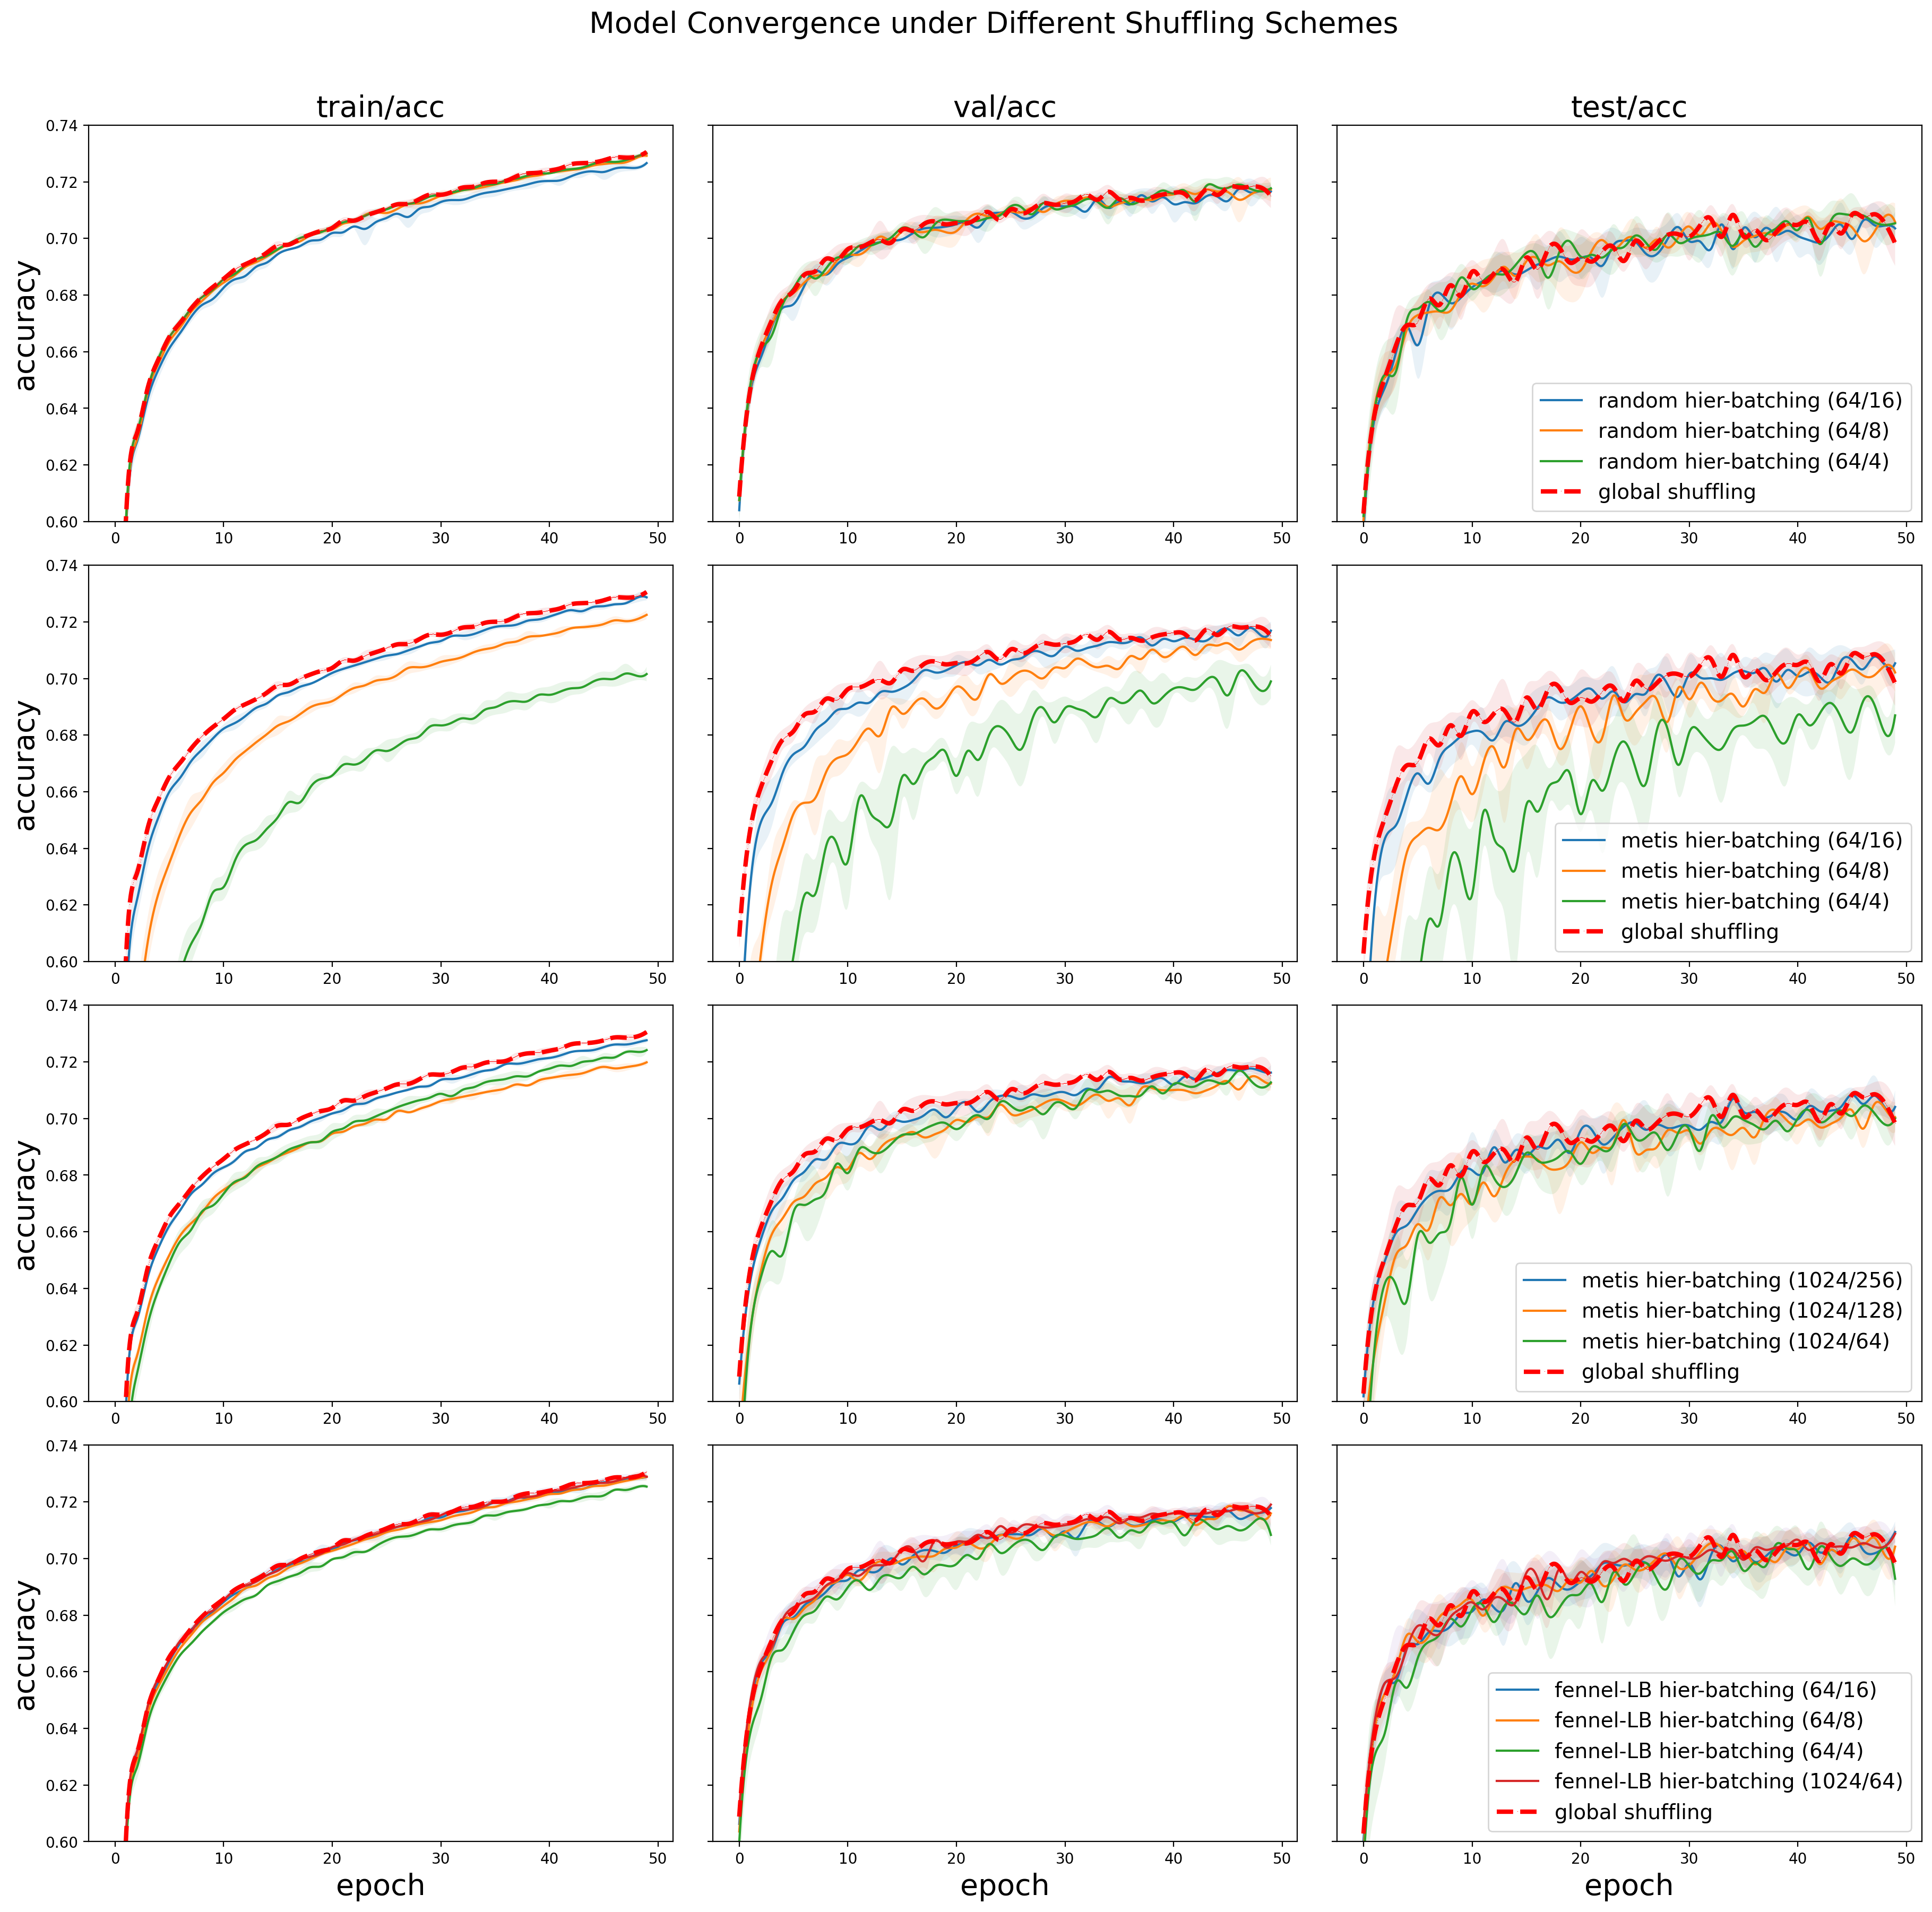

In [7]:
def extract_acc_curve(logs: list[Logger]):
    logs = sorted(logs, key=lambda log: (log.info.num_blocks, log.info.block_ratio))
    proc_data = {}
    for log in logs:
        info = log.info
        block_info = info.num_blocks, info.num_blocks // info.block_ratio
        acc_keys = ('train/acc', 'val/acc', 'test/acc')
        proc_data[block_info] = {
            k: [] for k in acc_keys
        }
        for run in log:
            run_acc = log.get_data(run, *acc_keys)
            for k in acc_keys:
                proc_data[block_info][k].append(run_acc[k])
    return proc_data

acc_series = {
    'random hier-batching': extract_acc_curve(rd_logs),
    'metis hier-batching': extract_acc_curve(hb_logs),
    'fennel-LB hier-batching': extract_acc_curve(fl_logs),
    'global shuffling': extract_acc_curve(gs_logs),
}

from scipy.interpolate import make_interp_spline
def make_conv_figure(axs, filter, ylim=[0.6, 0.74]):
    plt.ylim(ylim)
    for i, acc_type in enumerate(('train/acc', 'val/acc', 'test/acc')):
        ax = axs[i]
        if i == 0:
            ax.set_ylim(ylim)
        for shfl_method in acc_series:
            acc_blocks = acc_series[shfl_method]
            for block_info in acc_blocks:
                # if block_info[0] == block_info[1] or block_info[0] == 1024:
                #     continue
                if filter(shfl_method, block_info) and block_info[0] != block_info[1]:
                # if 'global' in shfl_method or (block_info[0] != block_info[1] and block_info[0]//block_info[1] != 8):
                    acc_curves = torch.tensor(acc_blocks[block_info][acc_type])
                    xs = range(acc_curves.size(1))
                    mean = acc_curves.mean(dim=0)
                    std = acc_curves.std(dim=0)
                    interp_xs = torch.arange(0, mean.size(0)-1, mean.size(0)/1000)
                    lower = make_interp_spline(xs, mean-std)(interp_xs)
                    upper = make_interp_spline(xs, mean+std)(interp_xs)
                    mean = make_interp_spline(xs, mean)(interp_xs)
                    label = shfl_method
                    if 'hier-batching' in shfl_method:
                        label += f' {block_info}'.replace(', ', '/')
                    if 'shuffling' in shfl_method:
                        ax.plot(interp_xs, mean, marker=',', label=label, color='red', ls='--', lw=3)
                    else:
                        ax.plot(interp_xs, mean, marker=',', label=label)
                    ax.fill_between(interp_xs, lower, upper, alpha=0.1, interpolate=True)
    ax.legend(fontsize=14)

fig, axs = plt.subplots(4, 3, figsize=(18, 18), sharey='row', dpi=200)
fig.tight_layout()
fig.suptitle(f"Model Convergence under Different Shuffling Schemes", fontsize=20)
fig.subplots_adjust(top=0.92)
make_conv_figure(axs[0], lambda shfl_method, block_info: 'shuffling' in shfl_method or 'random' in shfl_method)
make_conv_figure(axs[1], lambda shfl_method, block_info: 'shuffling' in shfl_method or 'metis' in shfl_method and block_info[0] != 1024)
make_conv_figure(axs[2], lambda shfl_method, block_info: 'shuffling' in shfl_method or 'metis' in shfl_method and block_info[0] == 1024)
make_conv_figure(axs[3], lambda shfl_method, block_info: 'shuffling' in shfl_method or 'fennel' in shfl_method)
for ax, title in zip(axs[0], ('train/acc', 'val/acc', 'test/acc')):
    ax.set_title(title, fontsize=20)
for ax in axs[:,0]:
    ax.set_ylabel('accuracy', fontsize=20)
for ax in axs[-1]:
    ax.set_xlabel('epoch', fontsize=20)
plt.show()
fig.savefig(
    'label_accuracy.pdf', bbox_inches = "tight"
)

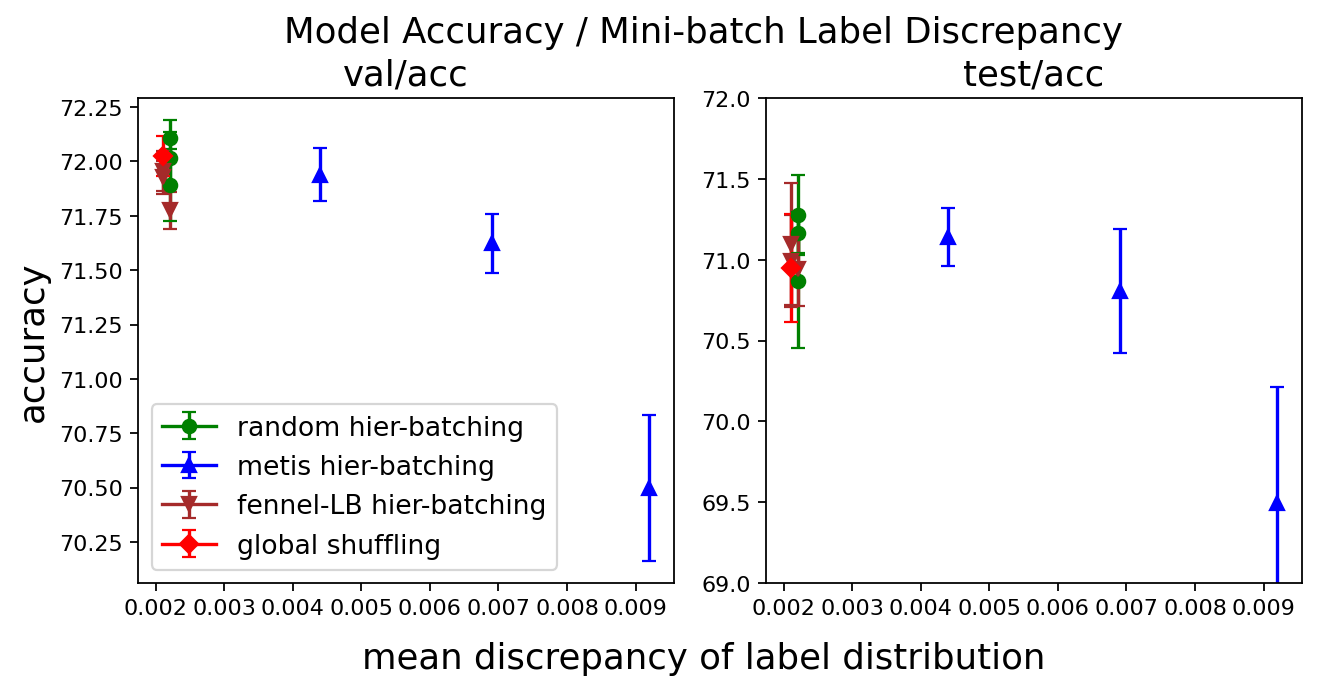

In [12]:
emd_dict = {
    'random hier-batching': {
        (64,4): 2.2e-3,
        (64,8): 2.2e-3,
        (64,16): 2.2e-3,
    },
    'metis hier-batching': {
        (64,4): 9.2e-3,
        (64,8): 6.9e-3,
        (64,16): 4.4e-3,
        # (1024,64): 4.2e-3,
        # (1024,128): 3.3e-3,
        # (1024,256): 2.8e-3,
    },
    'fennel-LB hier-batching': {
        (64,4): 2.2e-3,
        (64,8): 2.1e-3,
        (64,16): 2.1e-3,
        (1024,16): 2.1e-3,
    },
    'global shuffling': {
        (64,8): 2.1e-3,
    },
    'shuffling once': {
        (64,8): 2.1e-3,
    }
}

def extract_acc(logs: list[Logger]):
    acc_dict = {}
    for log in logs:
        info = log.info
        block_info = info.num_blocks, info.num_blocks // info.block_ratio
        acc_dict[block_info] = stdmean_acc(log)
    return acc_dict

acc_method_dict = {
    'random hier-batching': extract_acc(rd_logs),
    'metis hier-batching': extract_acc(hb_logs),
    'fennel-LB hier-batching': extract_acc(fl_logs),
    'global shuffling': extract_acc(gs_logs),
    # 'shuffling once': extract_acc(ss_logs),
}

style_dict = {
    'random hier-batching': {'marker': 'o', 'color': 'green'},
    'metis hier-batching': {'marker': '^', 'color': 'blue'},
    'fennel-LB hier-batching': {'marker': 'v', 'color': 'brown'},
    'global shuffling': {'marker': 'D', 'color': 'red'},
    'shuffling once': {'marker': 'h', 'color': 'orange'},
}

def make_acc_figure(ax, label, ylim=[68, 74], set_label=False):
    plt.ylim(ylim)
    for shfl_method in acc_method_dict:
        acc_dict = acc_method_dict[shfl_method]
        _set_label = set_label
        for block_info in acc_dict:
            if block_info[0] == block_info[1]:
                continue
            if block_info not in emd_dict[shfl_method]:
                continue
            mean, std = acc_dict[block_info][label]
            emd = emd_dict[shfl_method][block_info]
            if _set_label:
                ax.errorbar([emd], [mean], yerr=[std], capsize=3, **style_dict[shfl_method], label=shfl_method)
                _set_label = False
            else:
                ax.errorbar([emd], [mean], yerr=[std], capsize=3, **style_dict[shfl_method])
    if set_label:
        ax.legend(fontsize=12)
    ax.set_title(label, fontsize=16)

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, dpi=160)
fig.tight_layout()
fig.suptitle(f"Model Accuracy / Mini-batch Label Discrepancy", fontsize=16)
fig.subplots_adjust(top=0.85)
make_acc_figure(axs[0], 'val/acc', ylim=[70, 73], set_label=True)
make_acc_figure(axs[1], 'test/acc', ylim=[69, 72])
axs[0].set_ylabel('accuracy', fontsize=16)
fig.text(0.5, -0.04, 'mean discrepancy of label distribution', ha='center', fontsize=16)
fig.savefig("label_discrepancy.pdf", bbox_inches='tight')
plt.show()
